# Instructions

The goal of this task is to explore the Yelp data set to get a sense about what the data look like and their characteristics. You can think about the goal as being to answer questions such as:

1. What are the major topics in the reviews? Are they different in the positive and negative reviews? Are they different for different cuisines?
2. What does the distribution of the number of reviews over other variables (e.g., cuisine, location) look like?
3. What does the distribution of ratings look like?

In [412]:
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
import nltk
import spacy
from collections import Counter
from pprint import pprint

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_numeric, strip_short
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_non_alphanum, remove_stopwords, stem_text

import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED=26

## Step 1. Preprocessing
Using Yelp's dataset [example code](https://github.com/Yelp/dataset-examples), we first convert our datasets from json to csv so that we can use pandas for our exploratory analysis. (Note that we needed to use a Python 2 environment for this task.)  
`$ python json_to_csv_converter.py yelp_academic_dataset.json # Creates yelp_academic_dataset.csv`

```
%%bash
cd ../yelp_dataset_challenge_academic_dataset
ls -al
source activate py2
which python

for file in *.json; do
    echo $file
    python json_to_csv_converter.py $file
done
```

### 1a. Read data + Joins

In [294]:
%%time
# read in dataset and take sample
reviews = pd.read_csv("../data/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.csv", encoding='utf8')
business = pd.read_csv("../data/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.csv", encoding='utf8')
print(reviews.shape)
display(reviews.head())
print(business.shape)
display(business.head())

(1125458, 10)


<string>:2: DtypeWarning: Columns (1,4,7,14,18,21,27,30,43,49,52,62,64,66,70,84,89,92,100) have mixed types. Specify dtype option on import or set low_memory=False.


,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,Xqd0DzHaiyRqVH3WRG7hzg,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,5,2007-05-17,review,2
1,H1kH6QZV7Le4zqTRNxoZow,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",0,vcNAWiLM4dR7D2nwwJ7nCA,0,2,2010-03-22,review,2
2,zvJCcrpm2yOZrxKffwGQLA,-TsVN230RCkLYKBeLsuz7A,Dr. Goldberg has been my doctor for years and ...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-02-14,review,1
3,KBLW4wJA_fwoWmMhiHRVOA,dNocEAyUucjT371NNND41Q,Been going to Dr. Goldberg for over 10 years. ...,0,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-03-02,review,0
4,zvJCcrpm2yOZrxKffwGQLA,ebcN2aqmNUuYNoyvQErgnA,Got a letter in the mail last week that said D...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-05-15,review,2


(42153, 105)


,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,hours.Thursday.open,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,hours.Friday.open,categories,latitude,attributes.Outdoor Seating,attributes.Alcohol,attributes.Ambience.classy,attributes.Payment Types.mastercard,attributes.Parking.lot,business_id,attributes.Ambience.touristy,attributes.Corkage,hours.Tuesday.open,attributes.Good For.brunch,attributes.Payment Types.amex,name,hours.Monday.open,attributes.Waiter Service,attributes.Parking.street,attributes.Ambience.hipster,attributes.BYOB/Corkage,attributes.Hair Types Specialized In.straightperms,attributes.Music.live,attributes.Dietary Restrictions.dairy-free,attributes.Music.background_music,attributes.Price Range,attributes.Good For.breakfast,attributes.Parking.garage,attributes.Music.karaoke,attributes.Good For Dancing,review_count,attributes.Hair Types Specialized In.asian,state,attributes.Accepts Credit Cards,hours.Friday.close,attributes.Good For.lunch,attributes.Good For Kids,attributes.Parking.valet,attributes.Take-out,full_address,hours.Thursday.close,attributes.Hair Types Specialized In.coloring,attributes.Payment Types.cash_only,...,attributes.Ages Allowed,attributes.Ambience.trendy,attributes.Delivery,hours.Wednesday.close,attributes.Wi-Fi,open,city,attributes.Payment Types.discover,attributes.Wheelchair Accessible,attributes.Dietary Restrictions.gluten-free,stars,attributes.Payment Types.visa,type,attributes.Caters,attributes.Ambience.intimate,attributes.Music.playlist,attributes.Good For.latenight,attributes.Good For.dinner,attributes.Coat Check,longitude,hours.Monday.close,attributes.Hair Types Specialized In.extensions,hours.Tuesday.close,hours.Saturday.close,attributes.Good for Kids,attributes.Parking.validated,hours.Sunday.open,attributes.Accepts Insurance,attributes.Music.dj,attributes.Dietary Restrictions.soy-free,attributes.Has TV,hours.Sunday.close,attributes.Ambience.casual,attributes.By Appointment Only,attributes.Dietary Restrictions.kosher,attributes.Dogs Allowed,attributes.Drive-Thru,attributes.Dietary Restrictions.vegetarian,hours.Wednesday.open,attributes.Noise Level,attributes.Smoking,attributes.Attire,attributes.Hair Types Specialized In.curly,attributes.Good For Groups,neighborhoods,attributes.Open 24 Hours,attributes.Ambience.romantic,attributes.Hair Types Specialized In.perms,attributes.Music.jukebox,attributes.Ambience.upscale
0,NaN,NaN,NaN,08:00,NaN,NaN,NaN,NaN,08:00,"['Doctors', 'Health & Medical']",33.499313,NaN,NaN,NaN,NaN,NaN,vcNAWiLM4dR7D2nwwJ7nCA,NaN,NaN,08:00,NaN,NaN,"Eric Goldberg, MD",08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,AZ,NaN,17:00,NaN,NaN,NaN,NaN,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...",17:00,NaN,NaN,...,NaN,NaN,NaN,17:00,NaN,True,Phoenix,NaN,NaN,NaN,3.5,NaN,business,NaN,NaN,NaN,NaN,NaN,NaN,-111.983758,17:00,NaN,17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,08:00,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN
1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['Restaurants'],43.238893,False,none,False,NaN,True,JwUE5GmEO-sH1FuwJgKBlQ,False,NaN,NaN,False,NaN,Pine Cone Restaurant,NaN,True,False,False,NaN,NaN,NaN,NaN,NaN,1.0,False,False,NaN,NaN,26,NaN,WI,True,NaN,True,NaN,False,True,"6162 US Highway 51\nDe Forest, WI 53532",NaN,NaN,NaN,...,NaN,False,False,NaN,NaN,True,De Forest,NaN,NaN,NaN,4.0,NaN,business,False,False,NaN,False,False,NaN,-89.335844,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,average,NaN,casual,NaN,True,[],NaN,False,NaN,NaN,False
2,False,NaN,NaN,06:00,NaN,NaN,NaN,NaN,06:00,"['American (Traditional)', 'Restaurants']",43.252267,False,NaN,False,NaN,True,uGykseHzyS5xAMWoN6YUqA,False,NaN,06:00,True,NaN,Deforest Family Restaurant,06:00,True,False,False,NaN,NaN,NaN,NaN,NaN,1.0,False,False,NaN,NaN,16,NaN,WI,True,22:00,False,NaN,False,True,"505 W North St\nDe Forest, WI 5

CPU times: user 10.8 s, sys: 6.35 s, total: 17.1 s
Wall time: 27.6 s


For now, let's join some other interesting variables to our *review dataset* from the *business dataset* which we can use to perform some interesting analysis later on. In particular, cusine (`categories`) and location (`city` and `state`) seem interesting. We'll do a join between the datasets, and only keep columns that will be useful for our analysis (e.g. text, stars, etc...)

In [399]:
%%time
print(reviews.shape)
print(business.shape)
df_useful = pd.merge(reviews[['review_id', 'business_id', 'text', 'stars']], 
                     business[['business_id', 'categories', 'city', 'state']], 
                     on=['business_id'], how='inner').drop(columns=['business_id'], axis=1)
df_useful['city_state'] = df_useful['city'].str.upper() + ', ' + df_useful['state'].str.upper()
print(df_useful.shape)
display(df_useful.head())

(1125458, 10)
(42153, 105)
(1125458, 7)


,review_id,text,stars,categories,city,state,city_state
0,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,5,"['Doctors', 'Health & Medical']",Phoenix,AZ,"PHOENIX, AZ"
1,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",2,"['Doctors', 'Health & Medical']",Phoenix,AZ,"PHOENIX, AZ"
2,-TsVN230RCkLYKBeLsuz7A,Dr. Goldberg has been my doctor for years and ...,4,"['Doctors', 'Health & Medical']",Phoenix,AZ,"PHOENIX, AZ"
3,dNocEAyUucjT371NNND41Q,Been going to Dr. Goldberg for over 10 years. ...,4,"['Doctors', 'Health & Medical']",Phoenix,AZ,"PHOENIX, AZ"
4,ebcN2aqmNUuYNoyvQErgnA,Got a letter in the mail last week that said D...,4,"['Doctors', 'Health & Medical']",Phoenix,AZ,"PHOENIX, AZ"


CPU times: user 1.72 s, sys: 127 ms, total: 1.85 s
Wall time: 1.88 s


### 1b. Distribution Plots
Let's first plot the ratings distribution to answer one of the high level goals of our exploratoray data analysis. We see that the vast majority of the reviews are positive based on Yelp's rating system of 1-5 stars. We could always go back and look at the distribution of ratings across various categories or locations, but I'll leave that to another time.

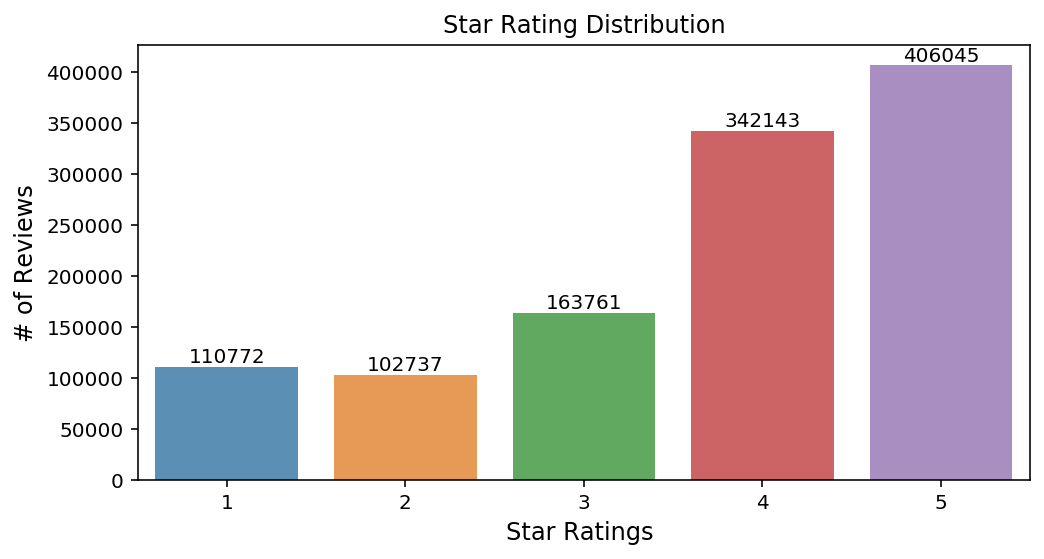

In [310]:
#Get the distribution of the ratings
x=df_useful['stars'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of Reviews', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

Now, let's look at the distribution of categories, filtered down to the top 10 most common categories. Although I commonly associate Yelp with restaurant reviews, this distribution plot reminds me that Yelp can also be used for reviews in other categories such as hotels.

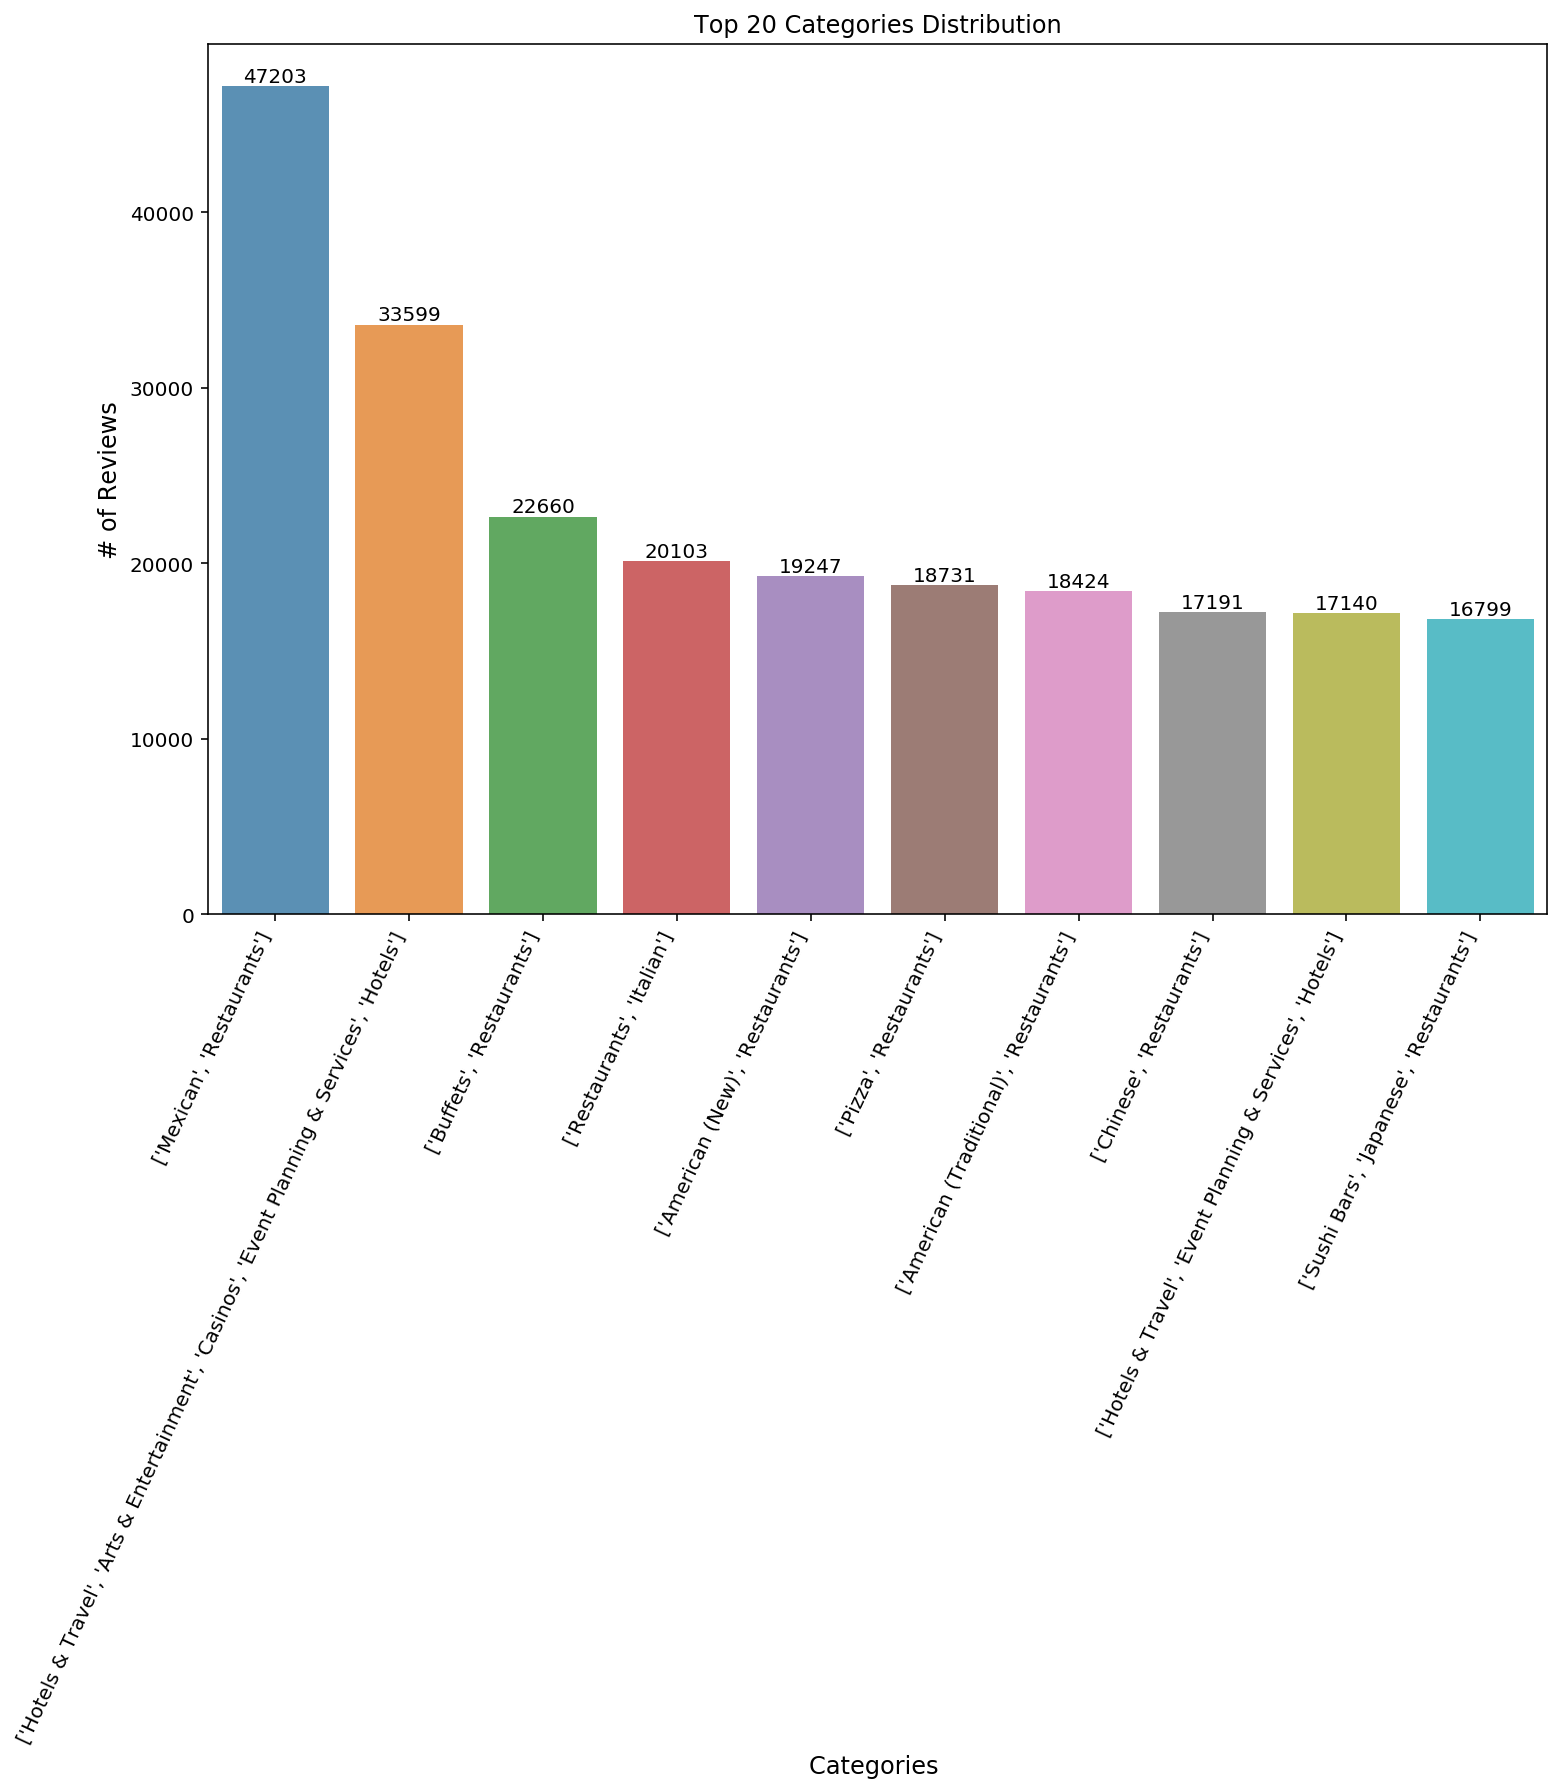

In [404]:
# keep 10 top categories/cuisines
vc = df_useful['categories'].value_counts(normalize=True)* 100
vals_keep = vc[:10].index.values
df_top_categories = df_useful[df_useful['categories'].isin(vals_keep)]
df_top_categories.shape

#Get the distribution of the ratings
x=df_top_categories['categories'].value_counts()
x=x.sort_values(ascending=False)
#plot
plt.figure(figsize=(12,8))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Top 20 Categories Distribution")
plt.ylabel('# of Reviews', fontsize=12)
plt.xlabel('Categories ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=65, horizontalalignment='right');

And now, let's also look at the distribution of reviews across the top 10 cities. Apparently they really like to use Yelp in Las Vegas and Arizona 🤷‍♂️. Also, Yelp is very much alive in London!

(1043642, 7)


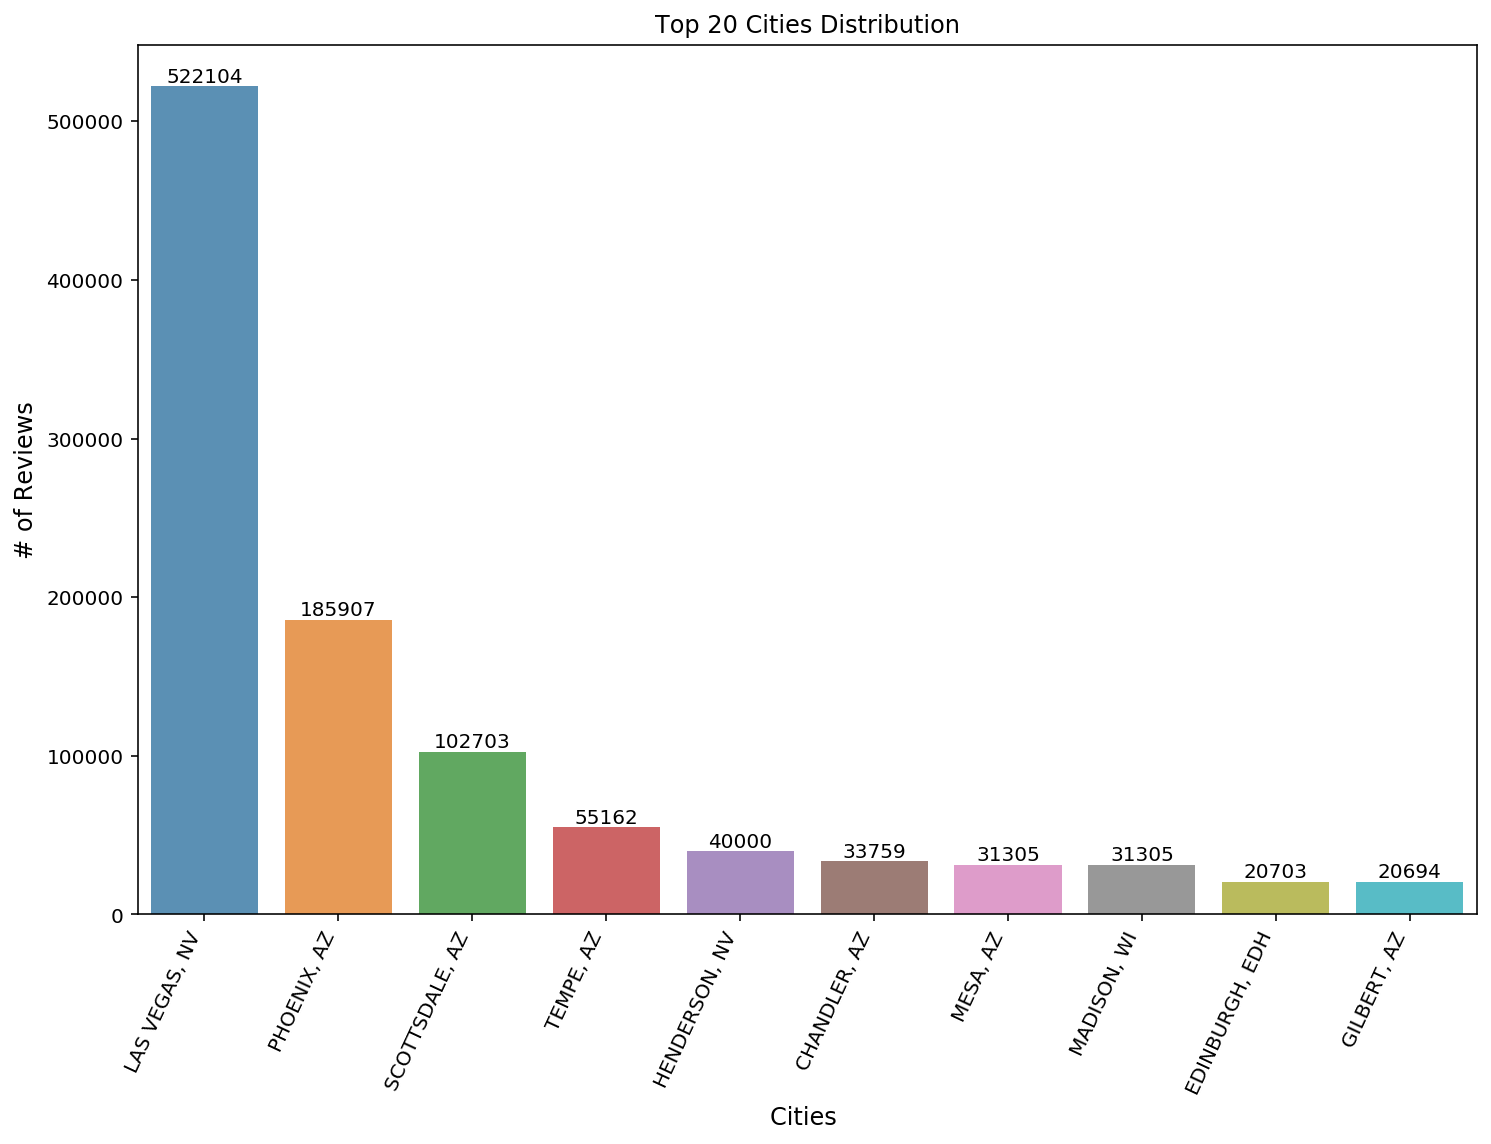

In [403]:
# keep 10 top categories/cuisines
vc = df_useful['city_state'].value_counts(normalize=True)* 100
vals_keep = vc[:10].index.values
df_top_states = df_useful[df_useful['city_state'].isin(vals_keep)]
print(df_top_states.shape)

#Get the distribution of the ratings
x=df_top_states['city_state'].value_counts()
x=x.sort_values(ascending=False)
#plot
plt.figure(figsize=(12,8))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Top 20 Cities Distribution")
plt.ylabel('# of Reviews', fontsize=12)
plt.xlabel('Cities ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=65, horizontalalignment='right');

### 1c. Sample + Preprocess
For our purposes, let us take a large random sample from the overall dataset.
Then, we perform some of the following preprocessing steps:
* tokenization
* remove punctuation, stopwords
* lemmatization + stemming
* construct bigiram and trigram models - just in case we mine such topics

At the end, we create a dictionary and corpus for our topic modeling.

In [392]:
reviews_sample = df_useful.sample(n=100, random_state=RANDOM_SEED).reset_index()
reviews_sample.head()
data = reviews_sample.text.values.tolist()

In [393]:
# tokenize and preprocess
# https://radimrehurek.com/gensim/parsing/preprocessing.html
FILTERS_LIST = [lambda x: x.lower(), # lowercase  
                strip_tags, # remove tags
                strip_punctuation, # replace punctuation characters with spaces
                strip_multiple_whitespaces, # remove repeating whitespaces
                strip_numeric, # remove numbers
                gensim.parsing.preprocessing.remove_stopwords, # remove stopwords
                strip_short] # remove words less than minsize=3 characters long]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.parsing.preprocessing.preprocess_string(str(sentence), FILTERS_LIST))
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def preprocess(reviews_list):
    "Combination of the preprocessing functions above."
    data_words = list(sent_to_words(reviews_list))
    # print(data_words[:3])
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return data_lemmatized

In [408]:
%%time
preprocessed_texts = preprocess(data)

# create Dictionary and corpus
id2word = corpora.Dictionary(preprocessed_texts)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in preprocessed_texts]

# View Human readable format of corpus (term-frequency)
# print(corpus[:1])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[['place', 'rocks', 'love', 'stinkweeds', 'great', 'selection', 'new', 'music', 'hang', 'listen', 'tracks', 'hours', 'employees', 'helpful', 'throw', 'want', 'hear', 'plus', 'business', 'owned', 'kimber', 'going', 'attract', 'people', 'community', 'buy', 'local', 'visit', 'stinkweeds'], ['great', 'little', 'restaurant', 'time', 'booked', 'turns', 'pretty', 'small', 'restaurant', 'sushi', 'tasty', 'fresh', 'service', 'wonderful', 'attentive', 'salads', 'delicious', 'new', 'sushi', 'place'], ['dad', 'favorite', 'chinese', 'restaurant', 'chinatown', 'sticky', 'rice', 'dish', 'probably', 'dish', 'order', 'pretty', 'tasty', 'super', 'sticky', 'menu', 'sub', 'par', 'normal', 'dirty', 'hole', 'wall', 'chinese', 'place', 'great', 'place', 'tends', 'busy', 'wouldn', 'recommend', 'hankering', 'sticky', 'rice']]


/Users/jonathan/anaconda/envs/dm_capstone/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/Users/jonathan/anaconda/envs/dm_capstone/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)


CPU times: user 5.54 s, sys: 1.81 s, total: 7.35 s
Wall time: 5.84 s


## Step 2 - Topic Model LDA (Task 1.1)
Use a topic model (e.g., PLSA or LDA) to extract topics from all the review text (or a large sample of them) and visualize the topics to understand what people have talked about in these reviews.

For this topic model, we use Gensim's LDA implementation to train a model on the corpus we just created from Yelp data and extract the top 10 topics. Again, we used id2word dictionary which contains our mapping between word IDs and the actual words. 

In [407]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=26,
                                           eval_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           iterations=100,
                                           per_word_topics=True)

CPU times: user 1.3 s, sys: 52.9 ms, total: 1.35 s
Wall time: 1.44 s


### 1.1a. Word Cloud

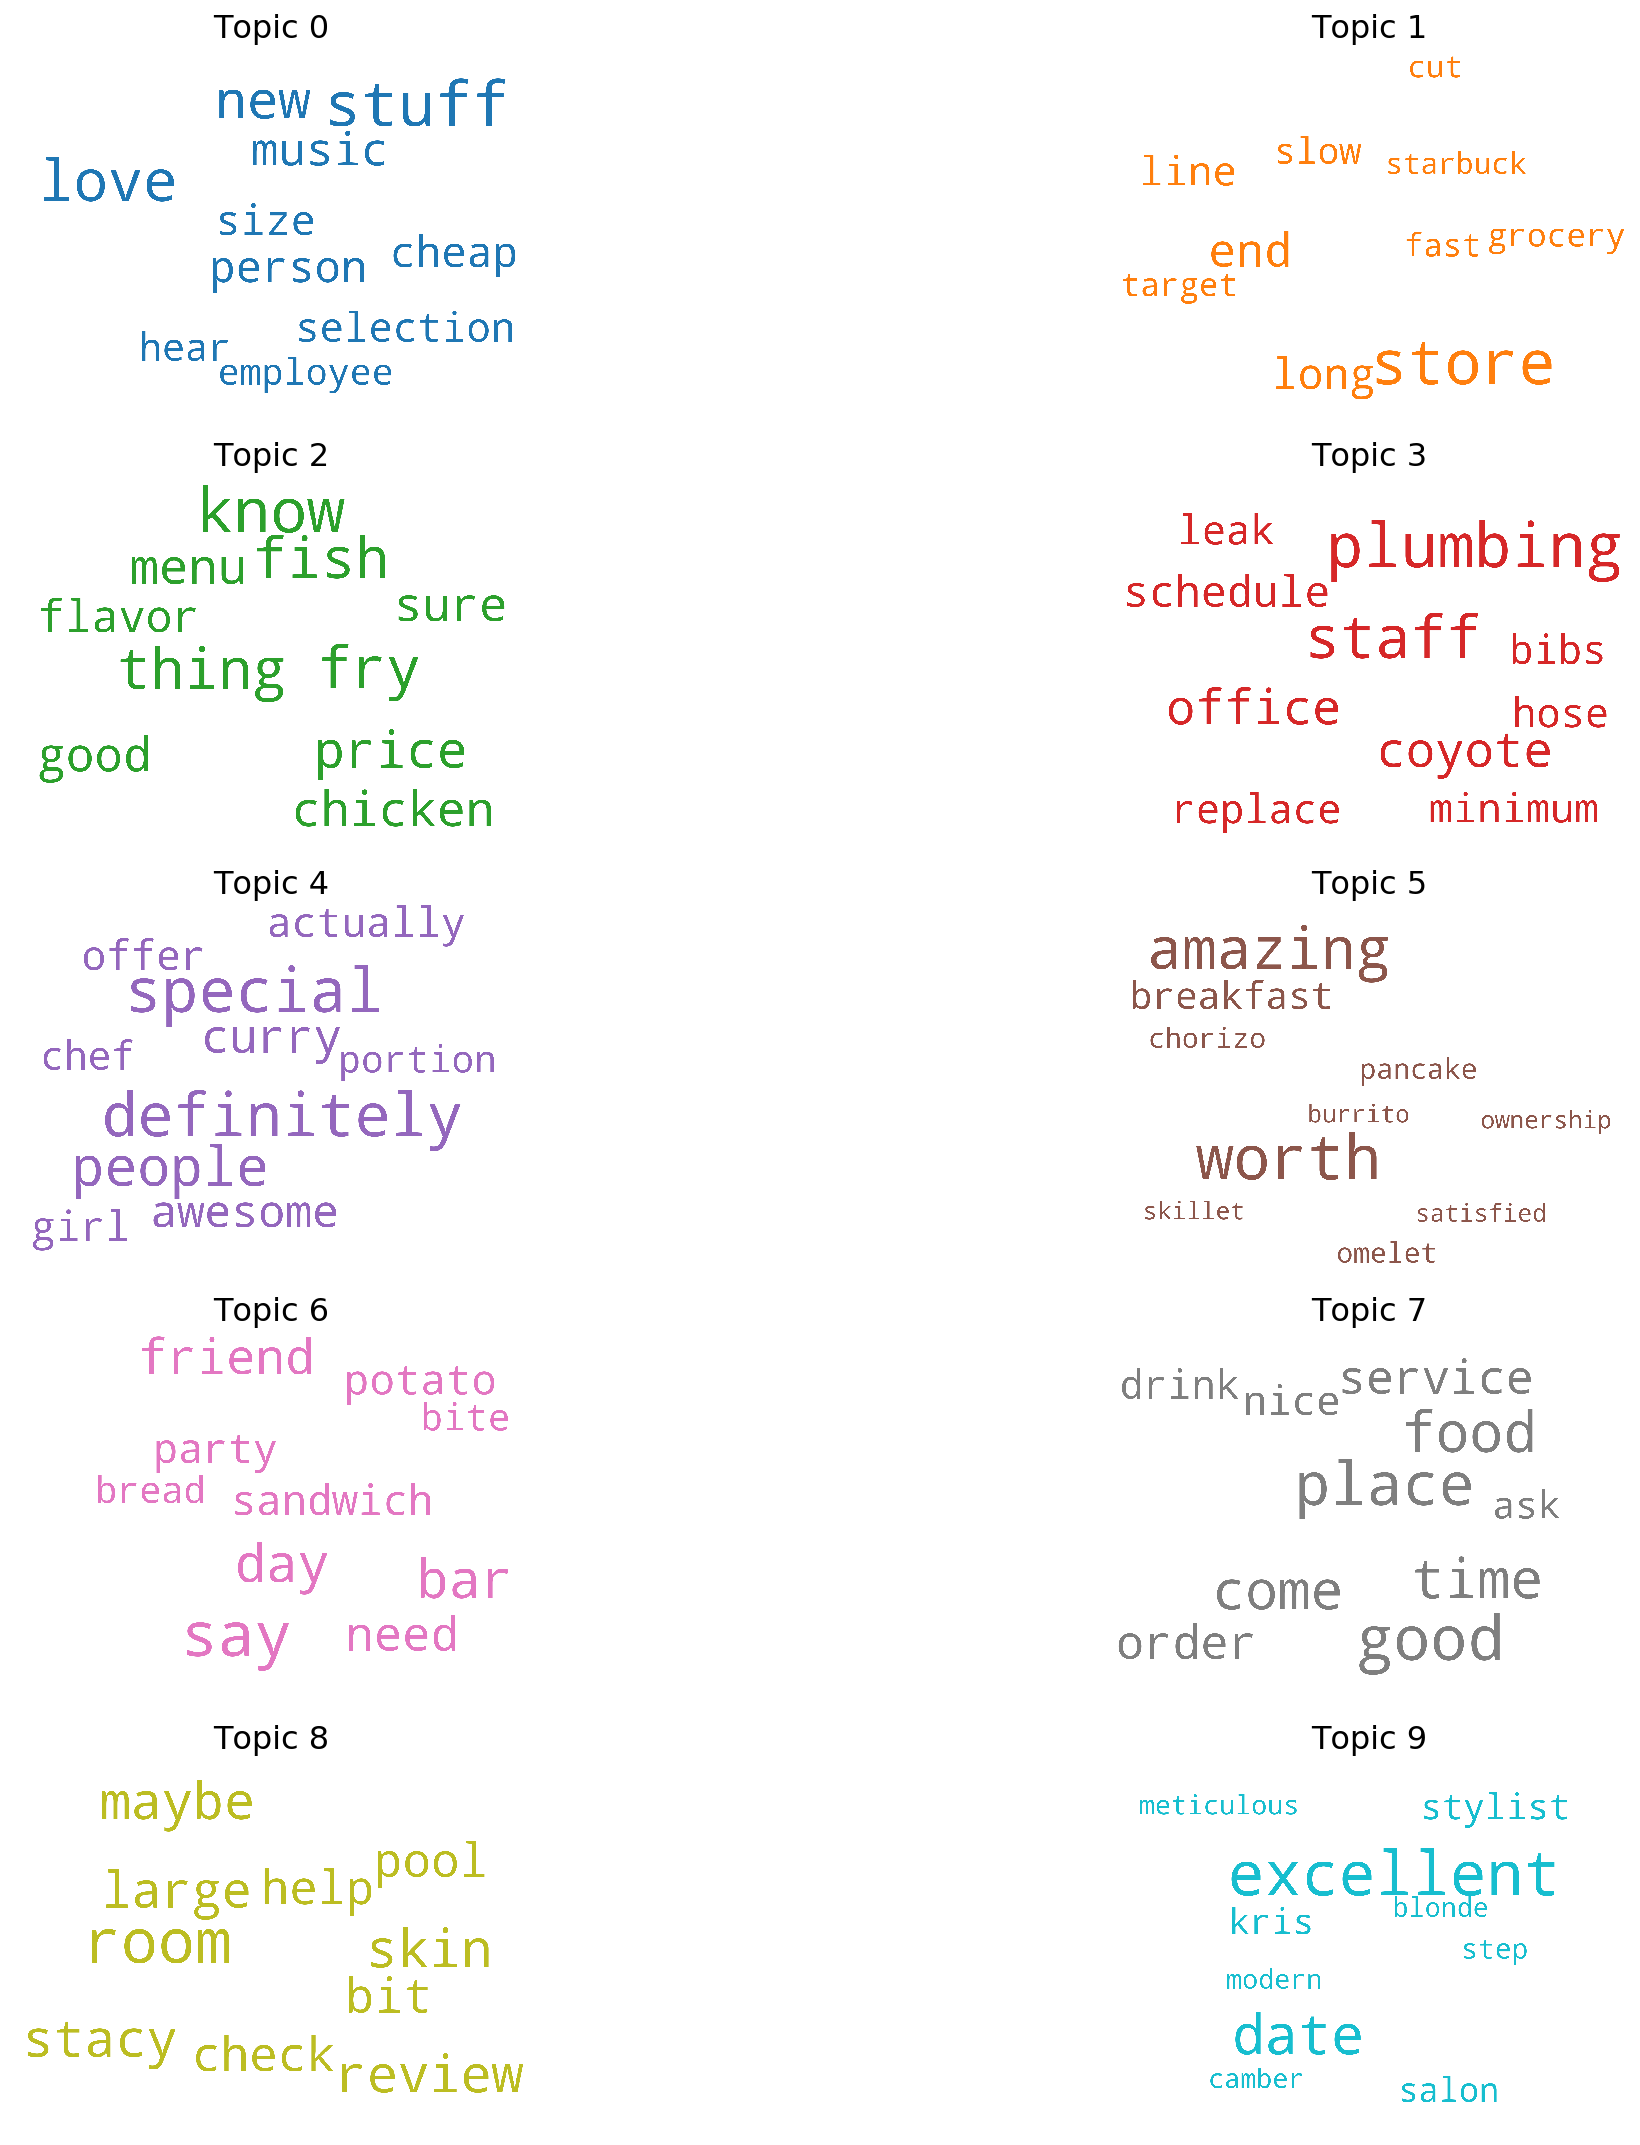

CPU times: user 10.9 s, sys: 2.22 s, total: 13.2 s
Wall time: 14.2 s


In [411]:
%%time
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 1.1b. Topical Word Counts

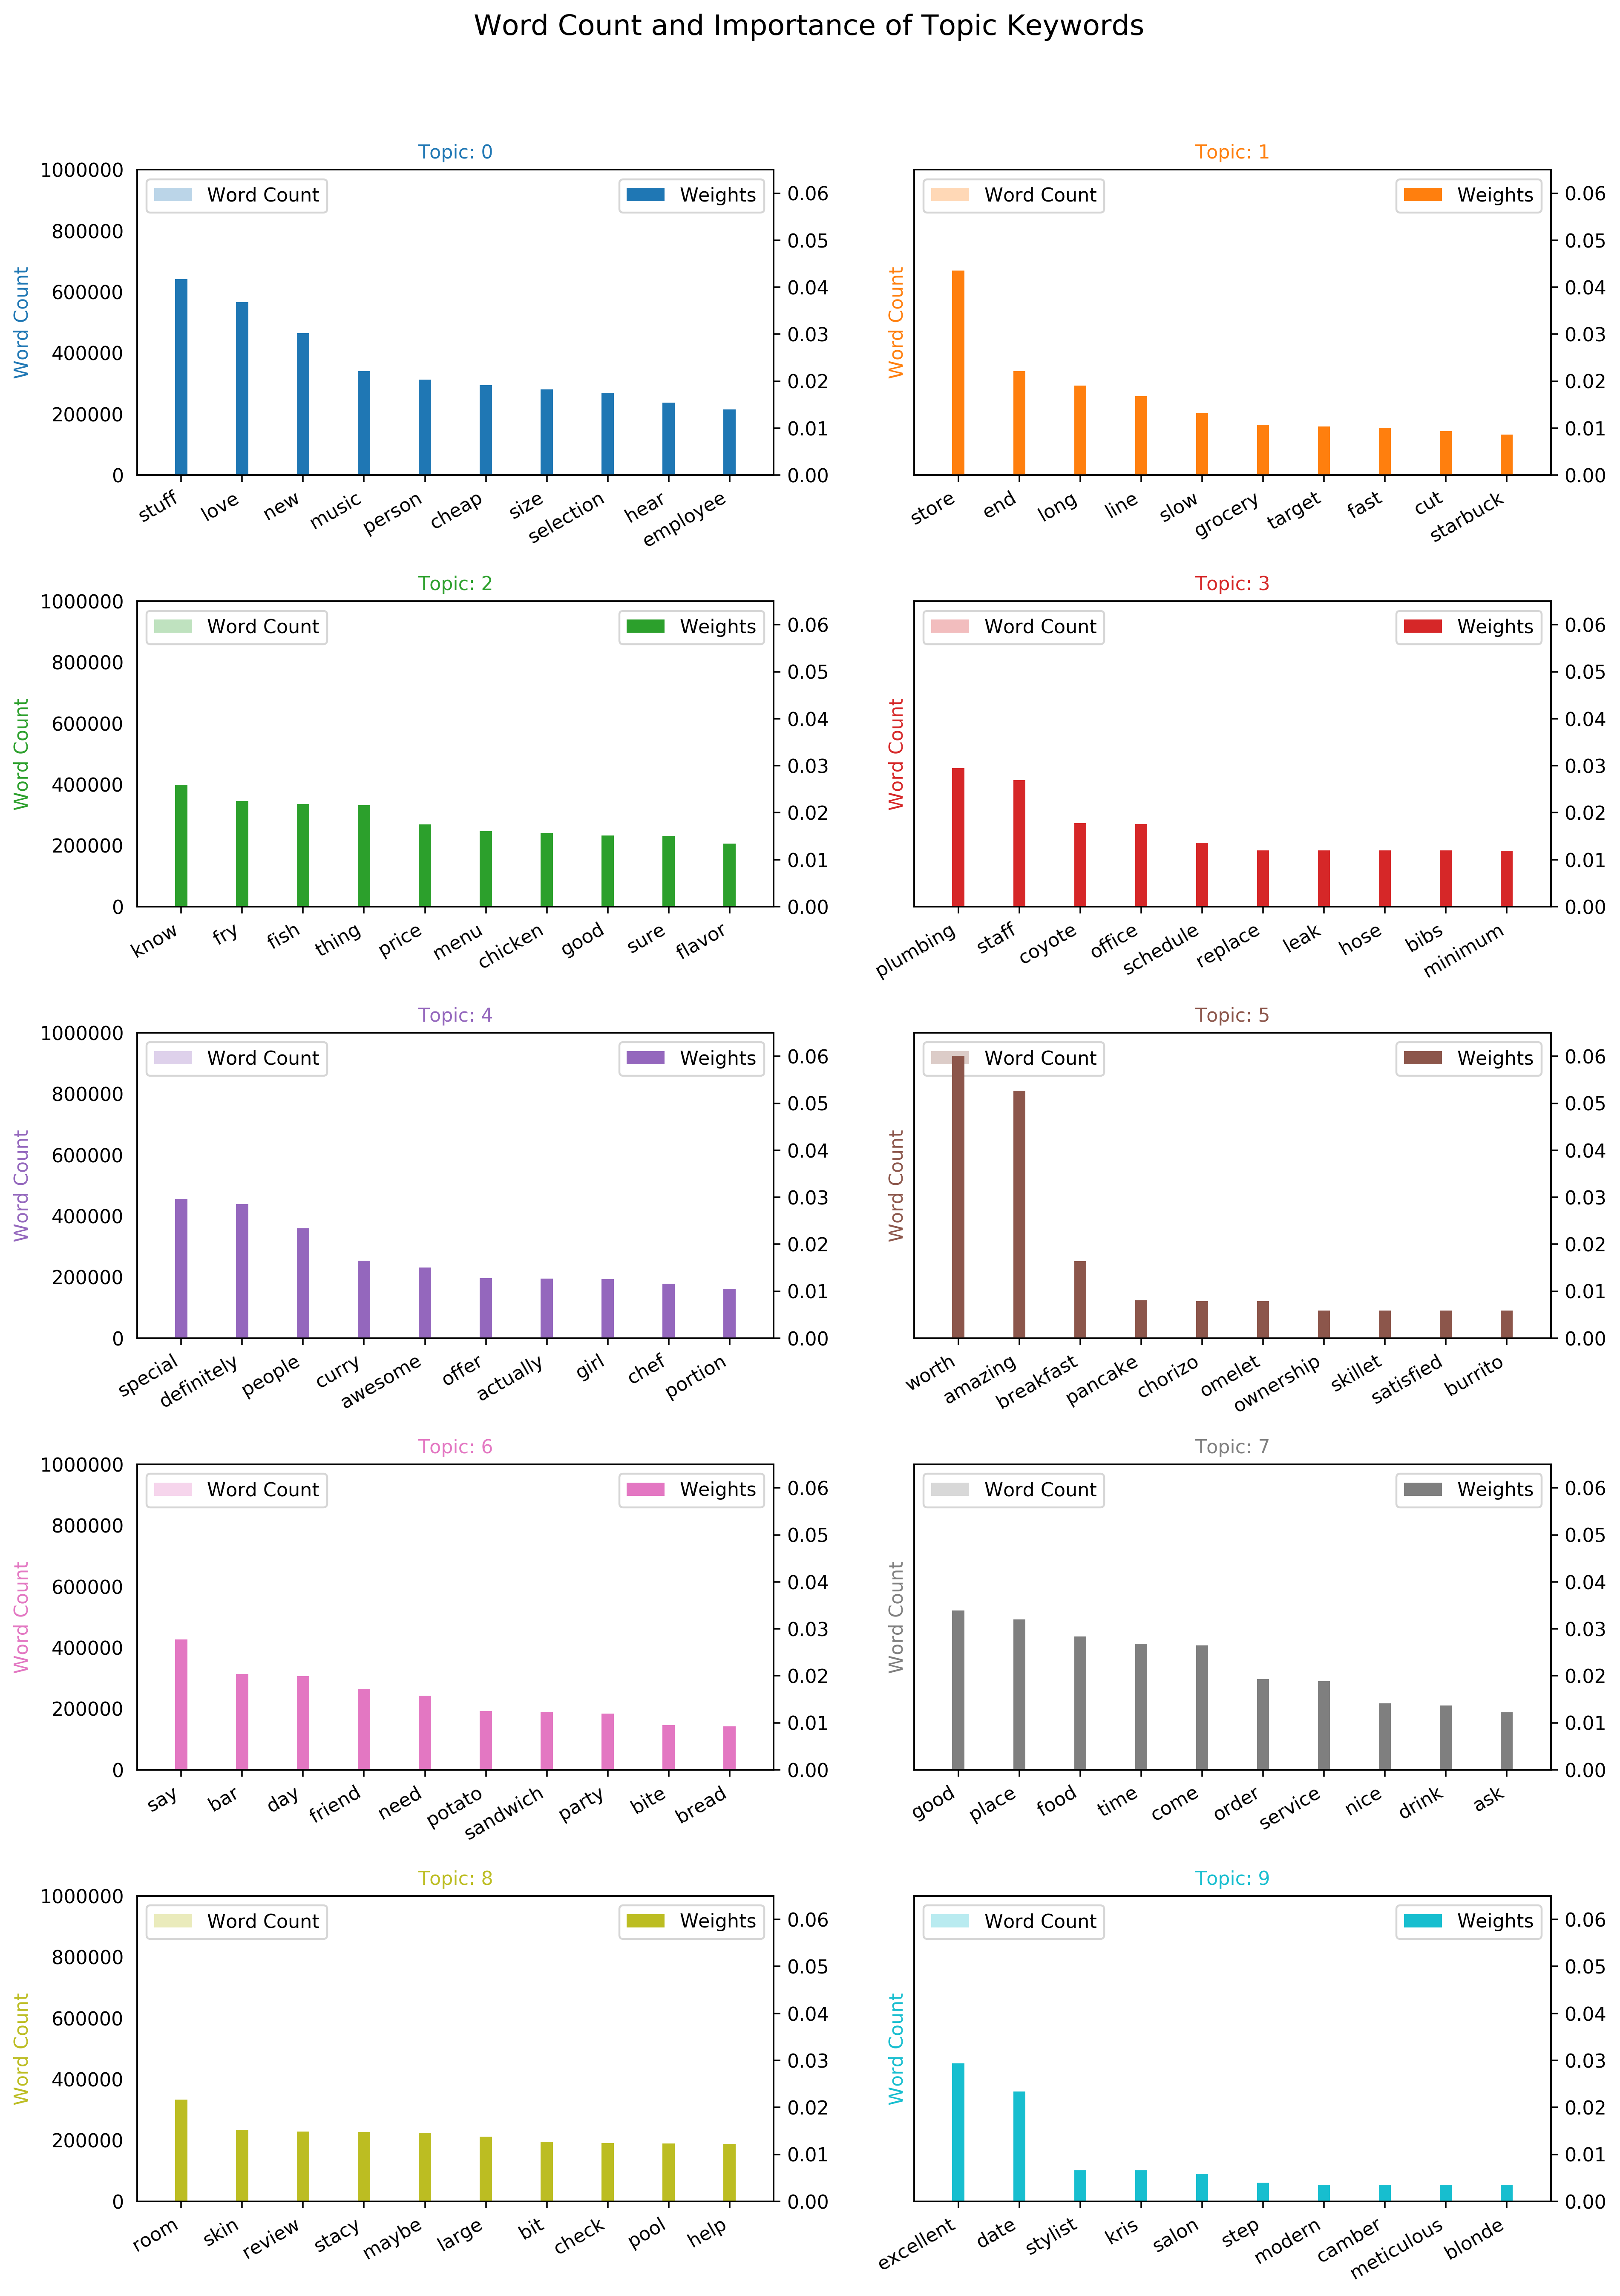

CPU times: user 5.4 s, sys: 90.7 ms, total: 5.49 s
Wall time: 5.52 s


In [429]:
%%time
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in preprocessed_texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(12,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.065); ax.set_ylim(0, 1000000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=15, y=1.05)    
plt.show()

### 1.1c. pyLDAvis - interactive topic model visualization
https://github.com/bmabey/pyLDAvis

In [171]:
%%time
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)
vis

/Users/jonathan/anaconda/envs/dm_capstone/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 1.91 s, sys: 756 ms, total: 2.67 s
Wall time: 39.8 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.362378  0.041316       1        1  35.834305
4      0.124126  0.254537       2        1  22.923553
2      0.072145 -0.192408       3        1  12.230344
3      0.035533 -0.051392       4        1   7.135645
7      0.007149 -0.020421       5        1   6.074358
1      0.030256  0.002402       6        1   3.942541
5      0.027322 -0.012404       7        1   3.390114
6      0.024906 -0.008902       8        1   3.262746
8      0.022674 -0.011054       9        1   2.701640
0      0.018267 -0.001675      10        1   2.504757, topic_info=    Category        Freq        Term       Total  loglift  logprob
21   Default  100.000000      review  100.000000  30.0000  30.0000
103  Default   78.000000        good   78.000000  29.0000  29.0000
20   Default   65.000000       place   65.000000  28.0000  28.0000
79   Default   52.000000        food   52.000000  27.0000  27.0000
44   Default   51.000000        time   51.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
880  Topic10    0.239304   txgxonjhl    0.827866   2.4459  -6.5022
864  Topic10    0.239304   enchilada    0.827866   2.4459  -6.5022
879  Topic10    0.239304       trick    0.827866   2.4459  -6.5022
878  Topic10    0.239304  tenderloin    0.827866   2.4459  -6.5022
876  Topic10    0.239304      soleil    0.827866   2.4459  -6.5022

[383 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
671       3  0.961679  absolutely
491       3  0.878441    actually
1435      3  0.913179         add
520       4  0.944760     alcohol
97        6  0.917107     amazing
...     ...       ...         ...
236       1  0.958227        work
2309      9  0.650169     working
108       6  0.911596       worth
456       2  0.931343       wrong
458       2  0.918840        year

[354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 3, 4, 8, 2, 6, 7, 9, 1])

## Task 1.2:

Do the same for two subsets of reviews that are interesting to compare (e.g., positive vs. negative reviews for a particular cuisine or restaurant), and visually compare the topics extracted from the two subsets to help understand the similarity and differences between these topics extracted from the two subsets. You can form these two subsets in any way that you think is interesting.

### 1.2a: LDA Positive Subset
To filter out positive reviews, we take a sample of reviews where the rating was greater than 4 stars.

In [288]:
%%time
positive_reviews = reviews[reviews['stars'] > 4]
positive_sample = positive_reviews.sample(n=10000, random_state=RANDOM_SEED).reset_index()

CPU times: user 142 ms, sys: 78.1 ms, total: 220 ms
Wall time: 273 ms


In [ ]:
%%time
data = positive_sample.text.values.tolist()
preprocessed_texts = preprocess(data)
id2word = corpora.Dictionary(preprocessed_texts)
corpus = [id2word.doc2bow(text) for text in preprocessed_texts]

In [ ]:
%%time
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 1.2b: LDA Negative Subset
We consider ratings of 1-2 stars as negative, and here we take a subset of negative reviews.

In [289]:
%%time
negative_reviews = reviews[reviews['stars'] < 3]
negative_sample = negative_reviews.sample(n=10000, random_state=RANDOM_SEED).reset_index()

CPU times: user 68.4 ms, sys: 27.3 ms, total: 95.7 ms
Wall time: 131 ms


In [ ]:
%%time
data = negative_sample.text.values.tolist()
preprocessed_texts = preprocess(data)
id2word = corpora.Dictionary(preprocessed_texts)
corpus = [id2word.doc2bow(text) for text in preprocessed_texts]

In [ ]:
%%time
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 1.2c: LDA Specific Business or Location Subset
I'm interested in topic modeling for `EDINBURGH, EDH`, the one location in the top 10 cities that was outside of the U.S., so we'll take a subset of reviews from Edinburgh.

In [431]:
%%time
uk_reviews = df_useful[df_useful['city_state'] == 'EDINBURGH, EDH']
uk_sample = uk_reviews.sample(n=10000, random_state=RANDOM_SEED).reset_index()

CPU times: user 130 ms, sys: 1.16 s, total: 1.28 s
Wall time: 3.2 s


In [ ]:
%%time
data = negative_sample.text.values.tolist()
preprocessed_texts = preprocess(data)
id2word = corpora.Dictionary(preprocessed_texts)
corpus = [id2word.doc2bow(text) for text in preprocessed_texts]

In [ ]:
%%time
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## References
* Gensim Docs - https://radimrehurek.com/gensim/models/phrases.html
* Preprocessing/LDA - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#4whatdoesldado
* Visualization - https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/